Please install those packages before running this file. If you have not done so, please uncomment the below code before running this file.

In [1]:
#load packages
from Bio import SeqIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets

In [2]:
def parse_fasta(fasta_file):
    sequences = []
    labels = []
    for record in SeqIO.parse(fasta_file, "fasta"):
        sequence = str(record.seq)
        # Extract the label from the sequence ID (assuming it's at the end and separated by '_')
        label = int(record.id.split('_')[-1])  # 0 or 1
        sequences.append(sequence)
        labels.append(label)
    return sequences, labels


In [3]:
import os 
# File paths
train_path = os.path.join('..', 'Data', 'Train.fasta')
test_path = os.path.join('..', 'Data', 'Test.fasta')

In [4]:
train_sequences, train_labels = parse_fasta(train_path)
test_sequences, test_labels = parse_fasta(train_path)

# Examining Class Ratio

In [5]:
# class ratio of training dataset
sum(train_labels)/(len(train_labels)-sum(train_labels)) # Class 1:Class 0 = 2:1

0.5040363554250875

In [6]:
# class ratio of test dataset
sum(test_labels)/(len(test_labels)-sum(test_labels)) # Class 1:Class 0 = 3:1

0.5040363554250875

# Examining Distribution of Protein Sequence Lengths

In [7]:
train_length = [len(seq) for seq in train_sequences]
test_length = [len(seq) for seq in test_sequences]

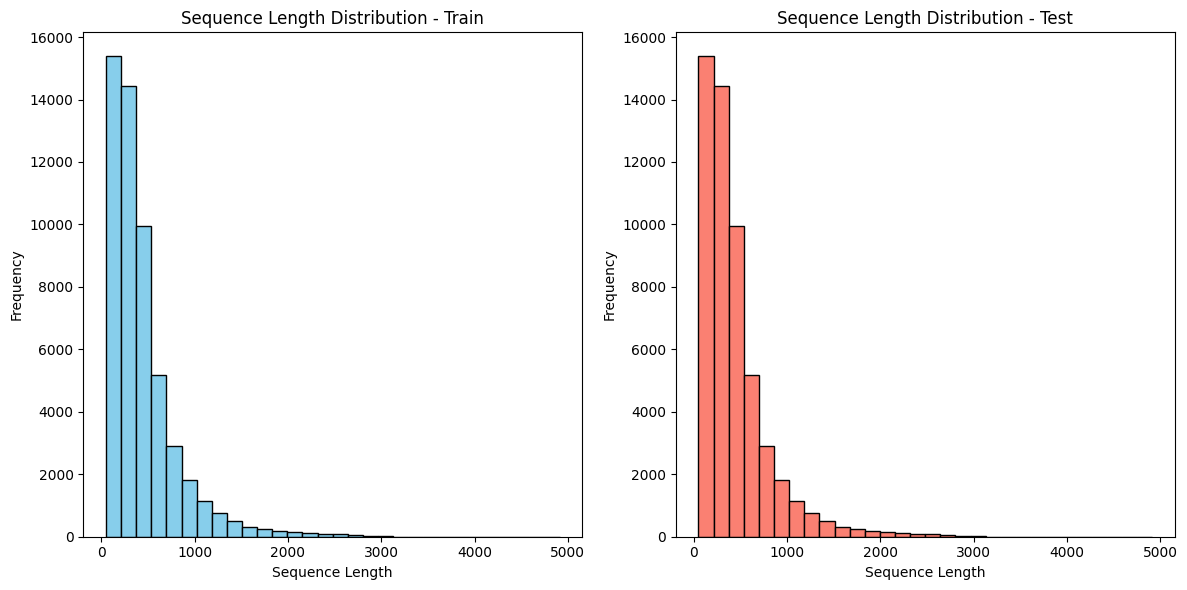

In [8]:
# Plot histograms side by side
plt.figure(figsize=(12, 6))

# Plot for train.fasta
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.hist(train_length, bins=30, color='skyblue', edgecolor='black')
plt.title('Sequence Length Distribution - Train')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

# Plot for test.fasta
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.hist(test_length, bins=30, color='salmon', edgecolor='black')
plt.title('Sequence Length Distribution - Test')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')

# Display the plot
plt.tight_layout()
plt.show()

Since we are using some embedding and tokenization techniques in our work, padding and truncation are also applied. We aim to take 95% of the dataset. Thus, the desired maximum length is 1200.

In [9]:
def cumulative_percentage(lengths):
    """Calculate the cumulative percentage distribution of sequence lengths."""
    sorted_lengths = np.sort(lengths)
    cumulative_percent = np.cumsum(np.ones_like(sorted_lengths)) / len(sorted_lengths) * 100
    return sorted_lengths, cumulative_percent

# Calculate cumulative distributions
train_sorted_lengths, train_cumulative_percent = cumulative_percentage(train_length)
test_sorted_lengths, test_cumulative_percent = cumulative_percentage(test_length)

# Find the cumulative percentage at max_length
max_length = 1200
train_percent = np.interp(max_length, train_sorted_lengths, train_cumulative_percent)
test_percent = np.interp(max_length, test_sorted_lengths, test_cumulative_percent)

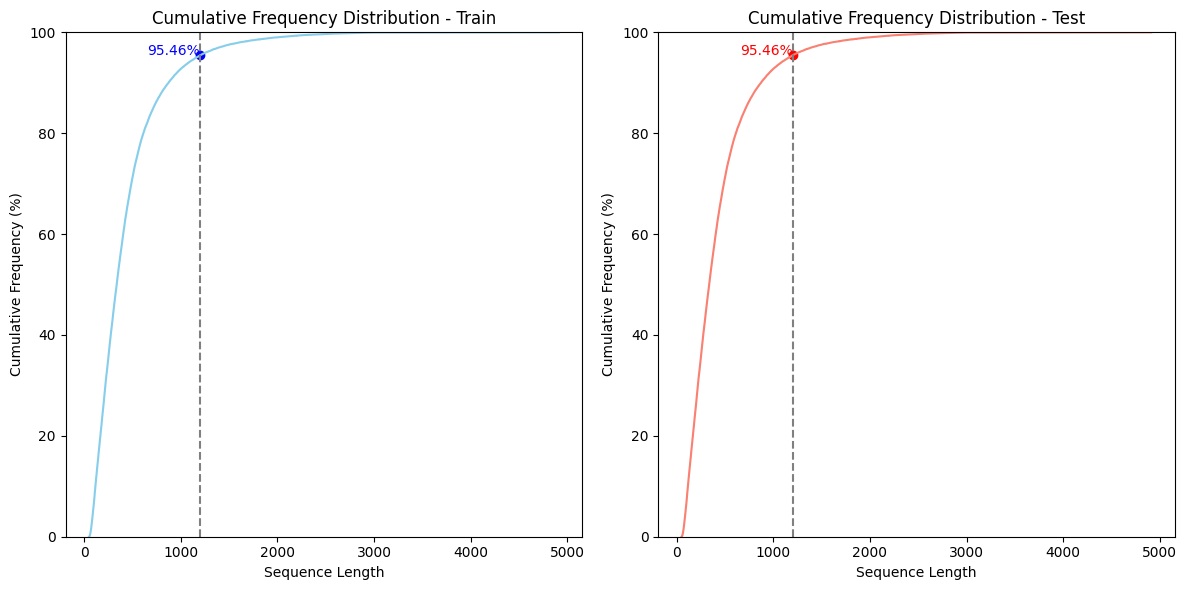

In [10]:
# Plot cumulative frequency distributions side by side
plt.figure(figsize=(12, 6))

# Train cumulative distribution plot
plt.subplot(1, 2, 1)
plt.plot(train_sorted_lengths, train_cumulative_percent, color='skyblue', label='Train')
plt.axvline(x=max_length, color='grey', linestyle='--')  # Vertical line at 1200
plt.scatter(max_length, train_percent, color='blue')  # Point at length 1200
plt.text(max_length, train_percent, f'{train_percent:.2f}%', ha='right', color='blue')
plt.title('Cumulative Frequency Distribution - Train')
plt.xlabel('Sequence Length')
plt.ylabel('Cumulative Frequency (%)')
plt.ylim(0, 100)

# Test cumulative distribution plot
plt.subplot(1, 2, 2)
plt.plot(test_sorted_lengths, test_cumulative_percent, color='salmon', label='Test')
plt.axvline(x=max_length, color='grey', linestyle='--')  # Vertical line
plt.scatter(max_length, test_percent, color='red')  # Point at max_length
plt.text(max_length, test_percent, f'{test_percent:.2f}%', ha='right', color='red')
plt.title('Cumulative Frequency Distribution - Test')
plt.xlabel('Sequence Length')
plt.ylabel('Cumulative Frequency (%)')
plt.ylim(0, 100)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Examining Global Amino Acid Distribution between Train vs Test dataset

In [11]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def calculate_character_distribution(sequences):
    """Calculate the global distribution of characters in a list of sequences."""
    char_count = Counter()
    total_chars = 0

    for sequence in sequences:
        char_count.update(sequence)
        total_chars += len(sequence)

    # Convert counts to percentages
    char_distribution = {char: (count / total_chars) * 100 for char, count in char_count.items()}
    return char_distribution



In [12]:
# Calculate distributions for train and test sets
train_distribution = calculate_character_distribution(train_sequences)
test_distribution = calculate_character_distribution(test_sequences)

# Get all unique characters from both distributions
all_chars = sorted(set(train_distribution.keys()).union(set(test_distribution.keys())))

# Prepare data for plotting
train_values = [train_distribution.get(char, 0) for char in all_chars]
test_values = [test_distribution.get(char, 0) for char in all_chars]


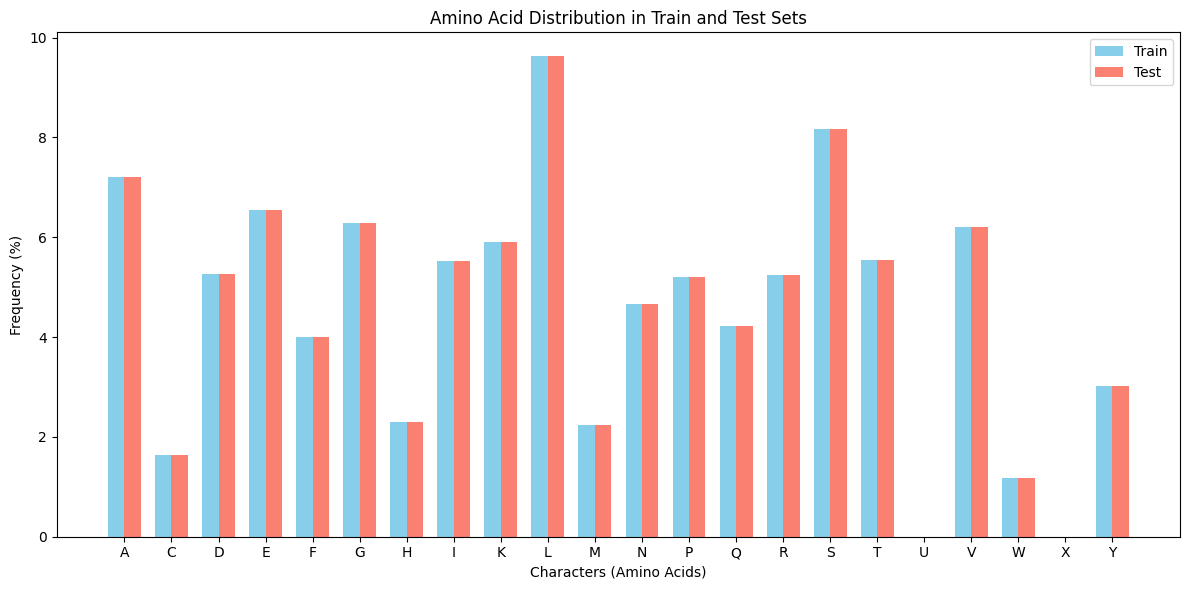

In [13]:
# Plot comparative bar graph
x = np.arange(len(all_chars))
width = 0.35  # Width of the bars

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, train_values, width, label='Train', color='skyblue')
plt.bar(x + width/2, test_values, width, label='Test', color='salmon')

# Labeling
plt.xlabel("Characters (Amino Acids)")
plt.ylabel("Frequency (%)")
plt.title("Amino Acid Distribution in Train and Test Sets")
plt.xticks(x, all_chars)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

# Examining Uncommon Amino Acid in Train & Test dataset

There are only 20 common amino acids found in protein sequences. Thus, we analyse what are uncommon amino acids found in our training and test dataset.

In [14]:
# Define the set of common amino acids
common_amino_acids = set("ARNDCEQGHILKMFPSTWYV")

In [15]:
def extract_uncommon_amino_acids(fasta_file, sequence_type):
    """Extract sequences with uncommon amino acids from a FASTA file."""
    data = []

    for record in SeqIO.parse(fasta_file, "fasta"):
        seq = str(record.seq)
        sequence_id = record.id
        uncommon_amino_acids = set(seq) - common_amino_acids

        # If there are uncommon amino acids, add a row to the data list
        if uncommon_amino_acids:
            data.append({
                "sequence_id": sequence_id,
                "type": sequence_type,
                "uncommon_amino_acids": ', '.join(uncommon_amino_acids)  # Convert set to comma-separated string
            })

    return data

In [16]:
# Extract uncommon amino acids for both train and test sets
train_data = extract_uncommon_amino_acids(train_path, "train")
test_data = extract_uncommon_amino_acids(test_path, "test")

# Combine data from both train and test into a single DataFrame
combined_data = train_data + test_data
df = pd.DataFrame(combined_data)

# Print the table
print(df.to_string(index=False))

      sequence_id  type uncommon_amino_acids
seq_13092_label_1 train                    X
seq_13353_label_1 train                    X
seq_13585_label_1 train                    X
seq_13649_label_1 train                    X
seq_13818_label_1 train                    X
seq_14467_label_1 train                    X
seq_14662_label_1 train                    X
seq_15675_label_1 train                    X
seq_15790_label_1 train                    X
seq_16795_label_1 train                    X
seq_17019_label_1 train                    X
seq_17270_label_1 train                    X
seq_50466_label_0 train                    X
seq_50717_label_0 train                    X
seq_51072_label_0 train                    X
seq_51145_label_0 train                    X
seq_51524_label_0 train                    X
seq_51801_label_0 train                    X
seq_51846_label_0 train                    U
seq_52269_label_0 train                    X
seq_52575_label_0 train                    X
seq_52717_

Among 24 train sequences that contain uncommon amino acid, only 1 of them contain amino acid 'U' (Selenocysteine), the rest contain unknown amino acid ('X').
There are only 3 test sequences that contain uncommon amino acid ('X').